# Car Object Detection AI

## Libraries

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import shutil as sh
import csv

from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.simplefilter("ignore", UserWarning)

## Data Creation & Preprocessing

In [2]:
df = pd.read_csv('./data/train_solution_bounding_boxes.csv')
df['image'] = df['image'].apply(lambda x: x.split('.')[0])

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have xmin, ymin, xmax, ymax values

In [3]:
index = list(set(df.image))
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(df.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['xmin','ymin','xmax','ymax']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/training_images/{}.jpg".format(name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1070.54it/s]


In [4]:
IMG_SIZE = 50
WIDTH = 676.0
HEIGHT = 380.0

### Create Training, Validation, and Test data

In [5]:
training_data = []
names = []

def create_training_data():
    for img in tqdm(os.listdir('./tmp/images/train/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/train/{}.jpg'.format(n) ,cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/train/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        training_data.append([img_array, lbl_array])

create_training_data()

100%|██████████| 355/355 [00:00<00:00, 3384040.73it/s]


In [6]:
val_data = []
names = []

def create_val_data():
    for img in tqdm(os.listdir('./tmp/images/val/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/val/{}.jpg'.format(n) ,cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/val/{}.txt'.format(n))
        if lbl_array.shape == (4,):
            lbl_array = np.array([lbl_array])
        # else:
        #     obj_num = lbl_array.shape[0]
            # print(n, obj_num)

        val_data.append([img_array, lbl_array])

create_val_data()
print(len(val_data))

100%|██████████| 355/355 [00:00<00:00, 3346017.80it/s]


355


In [7]:
random.shuffle(training_data)
random.shuffle(val_data)

In [8]:
x_train = []
y_train  = []
y_temp = []

for features,label in training_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_train.append(features)
        y_temp.append(label[i])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(WIDTH/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(HEIGHT/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(WIDTH/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(HEIGHT/IMG_SIZE)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_temp)

In [9]:
x_val = []
y_val  = []
y_temp = []

for features,label in val_data:
    obj_num = label.shape[0]
    for i in range(obj_num):
        x_val.append(features)
        y_temp.append(label[i])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(WIDTH/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(HEIGHT/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(WIDTH/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(HEIGHT/IMG_SIZE)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_temp)

## Training

### Create Model

In [10]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(4))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-19 03:43:19.949137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-19 03:43:19.949274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Train Model

In [11]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 10

In [12]:
NAME = 'Car-Object-Detection-{}'.format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data = (x_val, y_val), callbacks=[tensorboard, model_save])

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Epoch 1/10


2022-04-19 03:43:20.119257: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-19 03:43:20.278643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: -219073.4375 - accuracy: 0.0018

2022-04-19 03:43:20.991140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 47ms/step - loss: -219073.4375 - accuracy: 0.0018 - val_loss: -1086311.5000 - val_accuracy: 0.0000e+00
Epoch 2/10
18/18 [==============================] - 0s 22ms/step - loss: -5248099.0000 - accuracy: 0.0000e+00 - val_loss: -15332432.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
18/18 [==============================] - 0s 21ms/step - loss: -42490188.0000 - accuracy: 0.0000e+00 - val_loss: -96943056.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
18/18 [==============================] - 0s 20ms/step - loss: -203851664.0000 - accuracy: 0.0000e+00 - val_loss: -392011776.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
18/18 [==============================] - 0s 20ms/step - loss: -702467648.0000 - accuracy: 0.0000e+00 - val_loss: -1191961856.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
18/18 [==============================] - 0s 20ms/step - loss: -1905798400.0000 - accuracy: 0.0000e+00 - val_loss: -2980226048.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
18/18 [==

## Prediction

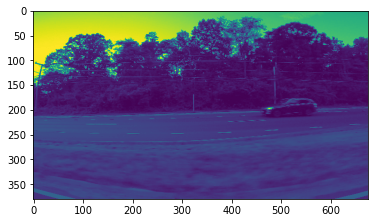

[[1. 1. 1. 1.]]


In [16]:
testing_names = []
for img in os.listdir('./data/testing_images/'):
    testing_names.append(img)

img_name = testing_names[random.randrange(0, len(testing_names))]
filepath = './data/testing_images/{}'.format(img_name)

raw_image = cv2.imread(filepath ,cv2.IMREAD_GRAYSCALE)
img_array = cv2.resize(raw_image, (IMG_SIZE, IMG_SIZE))
photo = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

prediction = model.predict([photo])

plt.imshow(raw_image)
plt.show()
print(prediction)

(13, 13) (13, 13)


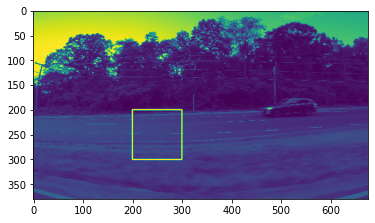

In [17]:
point1 = int(prediction[0][0]*(WIDTH/IMG_SIZE)),int(prediction[0][1]*(WIDTH/IMG_SIZE))
point2 = int(prediction[0][2]*(WIDTH/IMG_SIZE)), int(prediction[0][3]*(WIDTH/IMG_SIZE))
color = (255,0,0)
thickness = 2

print(point1, point2)

point1 = 200, 200
point2 = 300, 300

cv2.rectangle(raw_image, point1, point2, color, thickness)
plt.figure()
plt.imshow(raw_image)